### geospatial

 - first geospatial exploratory file

In [2]:
#general
import matplotlib.pyplot as plt
import numpy as np

#rasterio
import rasterio
import os
from rasterio.transform import from_bounds, from_origin
from rasterio.warp import reproject, Resampling

#richDEM
import richdem as rd

#elevation
#import elevation

#os
import os
import subprocess
from osgeo import gdal

#pyproj
import pyproj

#OSM
import osmnx as ox

# Geospatial Tool Exploration

## 1 Upload DEM (rasterio)

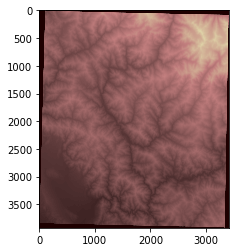

In [11]:
#dem_path = "n30_e078_1arc_v3.tif"
dem_path = "output.tif"
dem_raster = rasterio.open(dem_path)
array = dem_raster.read(1)

plt.imshow(array, cmap='pink', vmin=0, vmax=10000)
plt.show()

## 2 Pull DEM using elevation module

Following this tutorial: https://www.earthdatascience.org/tutorials/get-slope-aspect-from-digital-elevation-model/

Docs for elevation module: https://pypi.org/project/elevation/

In [12]:
!eio selfcheck

/bin/bash: eio: command not found


In [13]:
# dem_path = '/data/external/Utt.tif'
# output = os.getcwd() + dem_path
# elevation.clip(bounds=(78.5, 30.5, 79, 31), output=output, product='SRTM1')
# dem_raster = rasterio.open(dem_path)
# array = dem_raster.read(1)

# from matplotlib import pyplot
# pyplot.imshow(array, cmap='pink')
# pyplot.show()

## 3 Reproject to UTM

Purpose: Calculate slope and curvature when map is in meters (instead of degrees)

Decided the projection by looking for an UTM projection number calculator, knowing latitude and longitude. In this case, it is EPSG:32644. Can verify by looking at the region that EPSG:32644 covers - we'll see that it matches Uttarakhand: https://maps.omniscale.com/en/openstreetmap/epsg-32644

In [14]:
!gdalwarp -t_srs EPSG:32644 ./n30_e078_1arc_v3.tif output.tif

Processing ./n30_e078_1arc_v3.tif [1/1] : 0Using internal nodata values (e.g. -32767) for image ./n30_e078_1arc_v3.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


## 4 Calculate slope, aspect, curvature (richdem)

Following this tutorial: https://www.earthdatascience.org/tutorials/get-slope-aspect-from-digital-elevation-model/

All terraine attributes found here: https://richdem.readthedocs.io/en/latest/terrain_attributes.html

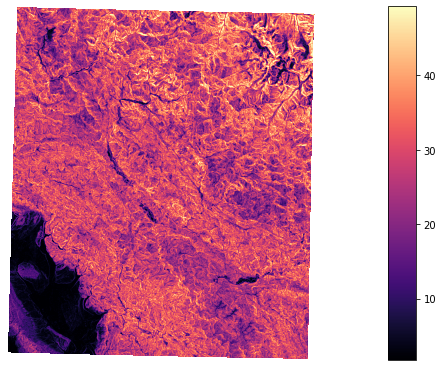

In [15]:
#slope
#dem_path = "n30_e078_1arc_v3.tif"
dem_path = "output.tif"
dem = rd.LoadGDAL(dem_path)
slope = rd.TerrainAttribute(dem, attrib='slope_degrees')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

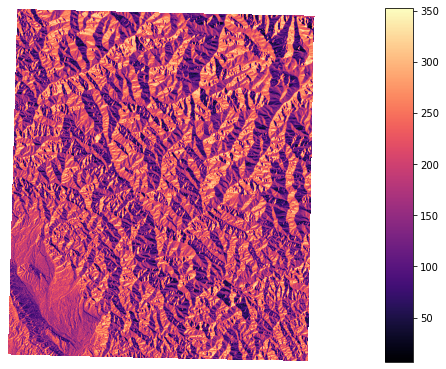

In [16]:
#aspect
aspect = rd.TerrainAttribute(dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

Curvature is a little weird - very high magnitudes. I think the issue is that the z-factor is off (see article here: https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/curvature-function.htm) because x and y are still in arcseconds and z is in meters, but I'm unsure of how to fix the issue (maybe the zloc parameter?).

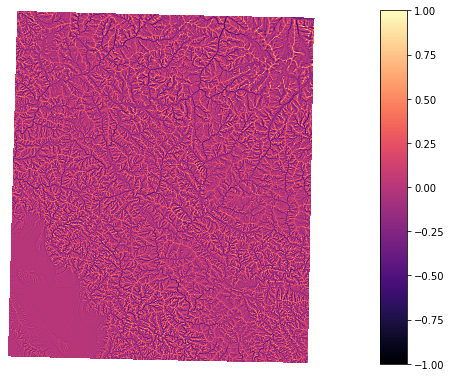

In [17]:
#curvature
curvature = rd.TerrainAttribute(dem, attrib='curvature')
#rd.rdShow(curvature, axes=False, cmap='magma', figsize=(8,5.5), vmin=-1000000000, vmax=1000000000)
rd.rdShow(curvature, axes=False, cmap='magma', figsize=(8,5.5), vmin=-1, vmax=1)
plt.show()

## 5 Spatial indexing

Using code from here: https://geohackweek.github.io/raster/04-workingwithrasters/

In [18]:
localname = "n30_e078_1arc_v3.tif"
lat_q = 30.8807
lon_q = 78.3975

with rasterio.open(localname) as src:
    elevation = src.read(1)
    
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')

    lon,lat = (30.8807, 78.3975)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    #print('Fresno NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    #find values
    elevation_val = elevation[row, col]
    slope_val = slope[row, col]
    aspect_val = aspect[row, col]
    curvature_val = curvature[row, col]
    print(f'elevation=\t\t\t{elevation_val:.2f}')
    print(f'slope=\t\t\t{slope_val:.2f}')
    print(f'aspect=\t\t\t{aspect_val:.2f}')
    print(f'curvature=\t\t\t{curvature_val:.2f}')

#     # Or if you see an interesting feature and want to know the spatial coordinates:
#     row, col = 200, 450
#     east, north = src.xy(row,col) # image --> spatial coordinates
#     lon,lat = pyproj.transform(utm, lonlat, east, north)
#     value = ndvi[row, col]
#     print(value)

lon,lat=		(30.88,78.40)
easting,northing=	(78.3975,30.8807)
row,col=		(429,1431)
elevation=			3469.00
slope=			27.50
aspect=			336.43
curvature=			0.60


/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
<ipython-input-18-760343580a14>:13: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  east,north = pyproj.transform(lonlat, utm, lon

## 6 Functions for slope, aspect, curvature (SAC)

In [19]:
def get_SAC_map(dem_path):
    dem = rd.LoadGDAL(dem_path)
    slope = rd.TerrainAttribute(dem, attrib='slope_degrees')
    aspect = rd.TerrainAttribute(dem, attrib='aspect')
    curvature = rd.TerrainAttribute(dem, attrib='curvature')
    return slope, aspect, curvature

def get_SAC_val(slope, aspect, curvature):
    

SyntaxError: invalid syntax (<ipython-input-19-95683b8fe811>, line 8)

## 7 OSM Road Network

In [1]:
G = ox.graph_from_bbox(30, 31, 78, 79, network_type='all')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

NameError: name 'ox' is not defined

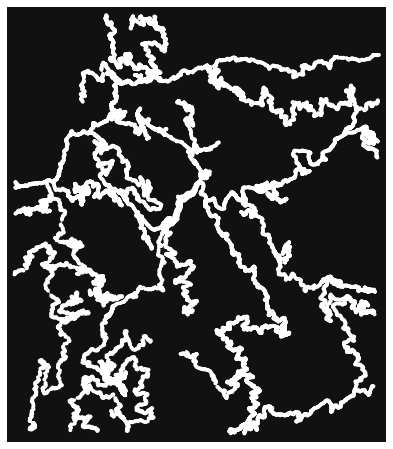

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
G = ox.graph_from_bbox(30, 30.2, 78.8, 79, network_type='all', simplify=False)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

In [5]:
ox.save_graph_geopackage(G_projected, filepath="roads.gpkg")

# Appendix

## 1 Reprojections

In [ ]:
north = 31
east = 79
west = 78
south = 30

src_crs = dem_raster.crs
src_shape = src_height, src_width = dem_raster.shape
src_transform = from_bounds(west, south, east, north, src_width, src_height)
source = dem_raster.read(1)

dst_crs = {'init': 'EPSG:32644'}
dst_transform = from_origin(0, 0, 30, 30)
dem_array = np.zeros((3601, 3601))
dem_array[:] = np.nan

reproject(source,
          dem_array,
          src_transform=src_transform,
          src_crs=src_crs,
          dst_transform=dst_transform,
          dst_crs=dst_crs,
          resampling=Resampling.bilinear)

## 2 Command Line Hacks

In [ ]:
#!gdalsrsinfo ./n30_e078_1arc_v3.tif

## 3 Slope and Aspect in GDAL

Tutorial from this youtube video: https://www.youtube.com/watch?v=5dDZeEXws9Q. 

Aspect looks good, but slope is off because the map needs to be reprojected to meters, instead of staying in degrees.

In [ ]:
def calculate_slope(DEM):
    slope = gdal.DEMProcessing('slope.tif', DEM, 'slope', computeEdges= True)
    slope_array = slope.GetRasterBand(1).ReadAsArray()
    return slope_array

def calculate_aspect(DEM):
    aspect = gdal.DEMProcessing('aspect.tif', DEM, 'aspect', computeEdges = True)
    aspect_array = aspect.GetRasterBand(1).ReadAsArray()
    return aspect_array

file = "n30_e078_1arc_v3.tif"
slope_array=calculate_slope(file)
aspect_array=calculate_aspect(file)

plt.imshow(slope_array)
#plt.clim(0, 90)
#plt.colorbar()
plt.show()

from matplotlib import pyplot
plt.imshow(aspect_array)
plt.clim(0, 360)
plt.colorbar()
plt.show()

## 4 Uploading slope map from QGIS

Hack from Stack Overflow for converting degrees to meter, knowing the latitude of the original map: https://gis.stackexchange.com/questions/143139/getting-incorrect-slope-values-from-an-aster-dem-in-qgis

Note that just due to the way that QGIS saves things, this slope tif is now 618x618 pixels, instead of the original 3601x3601. So we go from arcdegrees to a little more detail than arcminutes - big loss in resolution.

In [ ]:
dem_path = "slope_m.tif"
dem_raster = rasterio.open(dem_path)
slope_array = dem_raster.read(1)

plt.imshow(slope_array, cmap='pink')
plt.show()

## 5 Data query function

Simple function to find the slope and aspect of a lat/lon query point (lat_q and lon_q). 

In [ ]:
north, east, south, west = bounds = [31, 79, 30, 78]

lat_q = 30.8807
lon_q = 78.3975

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_values(lat_q, lon_q, bounds, array):
    size = len(array)
    step = 1/size
    north, east, south, west = bounds
    lat = np.arange(south, north, step)
    lon = np.arange(west, east, step)
    y = find_nearest(lat, lat_q)
    x = find_nearest(lon, lon_q)
    val = array[x,y]
    return val

def find_slope_aspect(lat_q, lon_q, bounds, slope_array, aspect_array):
    slope = find_value(lat_q, lon_q, bounds, slope_array)
    aspect = find_value(lat_q, lon_q, bounds, aspect_array)
    return slope, aspect

find_slope_aspect(lat_q, lon_q, bounds, slope_array, aspect_array)

## 6 Slope calculation (Datashader)

In [ ]:
import numpy as np
import xarray as xr
from xarray import DataArray
import datashader as ds
import datashader.geo as dsgeo
from datashader.transfer_functions import shade, stack
from datashader.colors import Elevation

import warnings
warnings.filterwarnings("ignore")

infile  = "n30_e078_1arc_v3.tif"
da_dem = xr.open_rasterio(infile).drop('band')[0]

# Have to check the res property.
# No support for res in both directioins of (x, y) or (lat, lon).
da_dem.attrs['res'] = da_dem.attrs['res'][0]
nodata = da_dem.nodatavals[0]
da_dem = da_dem.where(da_dem>nodata, np.nan)

shade(da_dem, cmap=['black', 'white'], how='linear')
shade(da_dem, cmap=Elevation, how='linear')

illuminated = dsgeo.hillshade(da_dem)
shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

stack(shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear'),
      shade(da_dem ,     cmap=Elevation,         alpha=128, how='linear'))

risky = dsgeo.aspect(da_dem)
#risky.data = np.where(np.logical_and(risky.data > 25, risky.data < 50), 1, np.nan)

stack(shade(risky,      cmap=['black', 'white'], how='linear'),)

## 7 Slope calculation (Arcpy)

In [ ]:
import arcpy
from arcpy import env
from arcpy.sa import *

inRaster1 = "n30_e078_1arc_v3.tif"
outRas = slope(inRaster1)
outRas.save("slopeRas")